In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Utah
state_ab = "ut"

## Data
1. Download all the data in directory "ut_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/ut_cong_2021.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_2021/ut_sldu_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_2021/ut_sldl_2021.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df)
    if maup.doctor(df):
        print('smart_repair successful')
            
        # change it back to this UTM for this data
        df = df.to_crs('EPSG:4269')
    else:
        raise Exception('smart_repair failed')
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)
    
    election_df = gpd.GeoDataFrame(election_df, crs="EPSG:4269")
    
    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]
    
    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col):    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)

    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated

    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs="EPSG:4269")
    df = gpd.GeoDataFrame(df, crs="EPSG:4269")
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    
    # check if population agrees
    check_population(population, df)
        
    return df

### Read the census data

In [11]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)

In [12]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [13]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')

In [14]:
maup.doctor(population_df)

100%|██████████| 71207/71207 [01:38<00:00, 724.42it/s] 


True

In [15]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [16]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [17]:
population_df.rename(columns=rename_dict, inplace = True)

In [18]:
cong_df = gpd.read_file(cd_data)
if maup.doctor(cong_df) != True:
    cong_df = do_smart_repair(cong_df)

100%|██████████| 4/4 [00:00<00:00, 25.71it/s]


## Read the vest 20 data

Now using it as a "base pricinct"

In [19]:
def add_vest_base(vest, start_col, year):
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs="EPSG:4269")
    
    return vest

## Check if vest20 can be used as base

In [20]:
vest20 = gpd.read_file(vest20_data)
if maup.doctor(vest20) != True:
    vest20 = do_smart_repair(vest20)

100%|██████████| 2424/2424 [00:05<00:00, 437.06it/s]


There are 1880 overlaps.
There are 9442 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 21637/21637 [00:29<00:00, 730.75it/s] 


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 9450it [1:08:19,  2.31it/s]                          
100%|██████████| 2424/2424 [00:05<00:00, 483.91it/s]


smart_repair successful


In [21]:
vest20.columns

Index(['CountyID', 'vistapre', 'resultspre', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREIPIE', 'G20PREIWES',
       'G20PREIMCH', 'G20PREILAR', 'G20PREOWRI', 'G20GOVRCOX', 'G20GOVDPET',
       'G20GOVLCOT', 'G20GOVADUE', 'G20GOVOWRI', 'G20ATGRREY', 'G20ATGDSKO',
       'G20ATGLBAU', 'G20AUDRDOU', 'G20AUDCOST', 'G20AUDUFAB', 'G20TRERDAM',
       'G20TRELSPE', 'G20TRECPRO', 'geometry'],
      dtype='object')

In [22]:
start_col = 3
vest_base_data = vest20
year = '20'

In [23]:
vest_base = add_vest_base(vest_base_data, start_col, year)

In [24]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████| 2424/2424 [00:20<00:00, 118.37it/s]


In [25]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [26]:
election_df = gpd.GeoDataFrame(vest_base, crs="EPSG:4269")

In [27]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID', 'GOV20D',
       'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O', 'TRE20R',
       'geometry', 'resultspre', 'vistapre', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [28]:
pd.DataFrame({
    'pop_col': pop_col,
    'population_df': population_df[pop_col].sum(), 
    'vest_base': vest_base[pop_col].sum(),
    'equal': [x == y for x, y in zip(population_df[pop_col].sum(), vest_base[pop_col].sum())]
})

,pop_col,population_df,vest_base,equal
TOTPOP,TOTPOP,3271616,3271616.0,True
HISP,HISP,492912,492912.0,True
NH_WHITE,NH_WHITE,2465355,2465355.0,True
NH_BLACK,NH_BLACK,37192,37192.0,True
NH_AMIN,NH_AMIN,28690,28690.0,True
NH_ASIAN,NH_ASIAN,78618,78618.0,True
NH_NHPI,NH_NHPI,35831,35831.0,True
NH_OTHER,NH_OTHER,12566,12566.0,True
NH_2MORE,NH_2MORE,120452,120452.0,True
H_WHITE,H_WHITE,108058,108058.0,True


## Add more vest data

In [29]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [30]:
vest18.columns

Index(['CountyID', 'mergeid', 'uniqueid', 'G18USSRROM', 'G18USSDWIL',
       'G18USSIMCC', 'G18USSLBOW', 'G18USSCAAL', 'G18USSOWRI', 'geometry'],
      dtype='object')

In [31]:
vest16.columns

Index(['CountyID', 'PrecinctID', 'county', 'precinct', 'G16PRERTRU',
       'G16PREDCLI', 'G16PRELJOH', 'G16PREISTE', 'G16PREIMCM', 'G16PREOOTH',
       'G16USSRLEE', 'G16USSDSNO', 'G16USSAFON', 'G16USSIBAR', 'G16GOVRHER',
       'G16GOVDWEI', 'G16GOVLKAM', 'G16GOVASCH', 'G16ATGRREY', 'G16ATGDHAR',
       'G16ATGLMCC', 'G16ATGAISB', 'G16AUDRDOU', 'G16AUDDMIT', 'G16AUDAGRE',
       'G16TRERDAM', 'G16TREDHAN', 'G16TRECPRO', 'geometry'],
      dtype='object')

In [32]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|██████████| 2337/2337 [00:06<00:00, 365.84it/s]


There are 1778 overlaps.
There are 10128 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 22762/22762 [00:29<00:00, 779.55it/s] 


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify:  98%|█████████▊| 9907/10136 [1:17:49<01:17,  2.96it/s]  

GEOSException: TopologyException: side location conflict at 458030.48999999999 4467307.64011. This can occur if the input geometry is invalid.

In [33]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID', 'GOV20D',
       'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O', 'TRE20R',
       'geometry', 'resultspre', 'vistapre', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

In [34]:
election_df = add_vest(vest16, election_df, '16', population_df, 4)

100%|██████████| 2296/2296 [00:04<00:00, 491.79it/s]


There are 1948 overlaps.
There are 9557 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|██████████| 21654/21654 [00:27<00:00, 790.18it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


GEOSException: TopologyException: side location conflict at 458030.48999999999 4467307.64011. This can occur if the input geometry is invalid.

##  Add the district data

In [35]:
send = gpd.read_file(send_data)
hdist = gpd.read_file(hdist_data)

Gaps to simplify:  98%|█████████▊| 9907/10136 [4:42:15<06:31,  1.71s/it]


In [36]:
cong_df.head()

,DISTRICTNO,TAPERSONS,VAPERSONS,geometry
0,1.0,817904.0,584771.0,"POLYGON ((-112.49352 41.07689, -112.50079 41.0..."
1,2.0,817904.0,594250.0,"POLYGON ((-114.05282 37.53103, -114.05283 37.5..."
2,3.0,817904.0,592597.0,"POLYGON ((-111.91429 40.45920, -111.91427 40.4..."
3,4.0,817904.0,552433.0,"POLYGON ((-112.35344 39.55526, -112.35163 39.5..."


In [37]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICTNO")

100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


In [38]:
send.head()

,DISTRICTNO,TAPERSONS,VAPERSONS,geometry
0,1.0,110855.0,73770.0,"POLYGON ((-114.04400 40.68998, -114.04400 40.6..."
1,2.0,111491.0,80463.0,"POLYGON ((-112.16601 41.99618, -112.16577 41.9..."
2,3.0,112971.0,81369.0,"POLYGON ((-112.01667 41.32123, -112.01572 41.3..."
3,4.0,113791.0,78686.0,"POLYGON ((-112.49341 41.07700, -112.48324 41.0..."
4,5.0,112790.0,82763.0,"POLYGON ((-112.03909 41.11807, -112.03764 41.1..."


In [39]:
election_df = add_district(send, "SEND", election_df, "DISTRICTNO")

100%|██████████| 29/29 [00:01<00:00, 18.72it/s]


In [40]:
hdist.head()

,DISTRICTNO,TAPERSONS,VAPERSONS,geometry
0,1.0,43137.0,29337.0,"POLYGON ((-114.04202 41.00156, -114.04195 41.0..."
1,2.0,43892.0,29836.0,"POLYGON ((-112.04335 41.83757, -112.04317 41.8..."
2,3.0,43860.0,34965.0,"POLYGON ((-111.90172 41.74938, -111.90148 41.7..."
3,4.0,43697.0,31102.0,"POLYGON ((-111.85724 41.13729, -111.85723 41.1..."
4,5.0,43323.0,27924.0,"POLYGON ((-112.05186 41.70016, -112.05170 41.7..."


In [41]:
hdist = hdist.to_crs("EPSG:4269")
election_df = add_district(hdist, "HDIST", election_df, "DISTRICTNO")

100%|██████████| 75/75 [00:01<00:00, 49.72it/s]


In [42]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID', 'GOV20D',
       'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O', 'TRE20R',
       'geometry', 'resultspre', 'vistapre', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CD', 'SEND', 'HDIST'],
      dtype='object')

### Put the base precinct year after the precinct information column

In [43]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'CountyID':'CountyID'+year,
        'vistapre':'vistapre'+year,
        'resultspre':'resultspre'+year}
election_df.rename(columns=base_columns, inplace = True)

In [44]:
election_df.columns

Index(['ATG20D', 'ATG20O', 'ATG20R', 'AUD20O', 'AUD20R', 'CountyID20',
       'GOV20D', 'GOV20O', 'GOV20R', 'PRE20D', 'PRE20O', 'PRE20R', 'TRE20O',
       'TRE20R', 'geometry', 'resultspre20', 'vistapre20', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [45]:
# reorder the columns
fixed_columns = [
    'CountyID'+year,
    'vistapre'+year,
    'resultspre'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [46]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}/{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

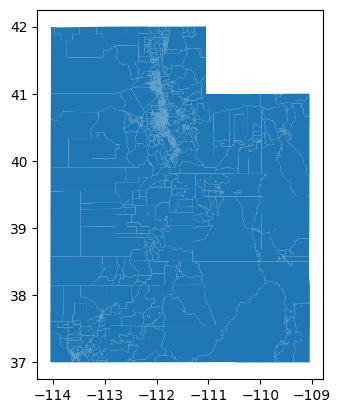

In [47]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()